# CNN-based Brain Tumour Detector
## Import packages
Please make sure you have all the required packages installed. If GPU is available, but you want to use CPU to train your model, make sure you add " os.environ['CUDA_VISIBLE_DEVICES'] = '-1' " before "from keras.preprocessing.image import ImageDataGenerator"

In [1]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import shutil

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
# from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
# from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input

from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

E:\ANACONDAw\envs\tf1.13\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\ANACONDAw\envs\tf1.13\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\ANACONDAw\envs\tf1.13\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\ANACONDAw\envs\tf1.13\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

## Data preparation (this step has been done for you)

Images in the original dataset are usually in different sizes, so we need to resize and normalise them to fit the CNN model. Depending on the images you choose to use for training your model, some other preprocessing methods (cropping, zooming, etc.) may be required.


## Split your dataset into training and validation
Validation dataset would not be used to train your network, it is normally for evaluating your model performance and choosing the best set of hyperparameters. Choose the size of your training and validation set yourself.

In [2]:
#uncomment if using linux/macos
#!rm -rf Train Val
#!mkdir Train Val Train/yes Train/no Val/yes Val/no

#uncomment if using windows
!rmdir Train1 Val1 /s /q
!md Train1 Val1 Train1\yes Train1\no Val1\yes Val1\no


IMG_PATH = 'Dataset/'
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        files = os.listdir(IMG_PATH + CLASS)
        random.shuffle(files)
        IMG_NUM = len(files)
        for (n, FILE_NAME) in enumerate(files):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            # 80% of images will be used for training, change the number here 
            # to use different number of images for training your model.
            if n < 0.6*IMG_NUM:
                shutil.copy(img, 'Train1/'+ CLASS + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'Val1/'+ CLASS + '/' + FILE_NAME)

## Plot images
Plot some sample images here.

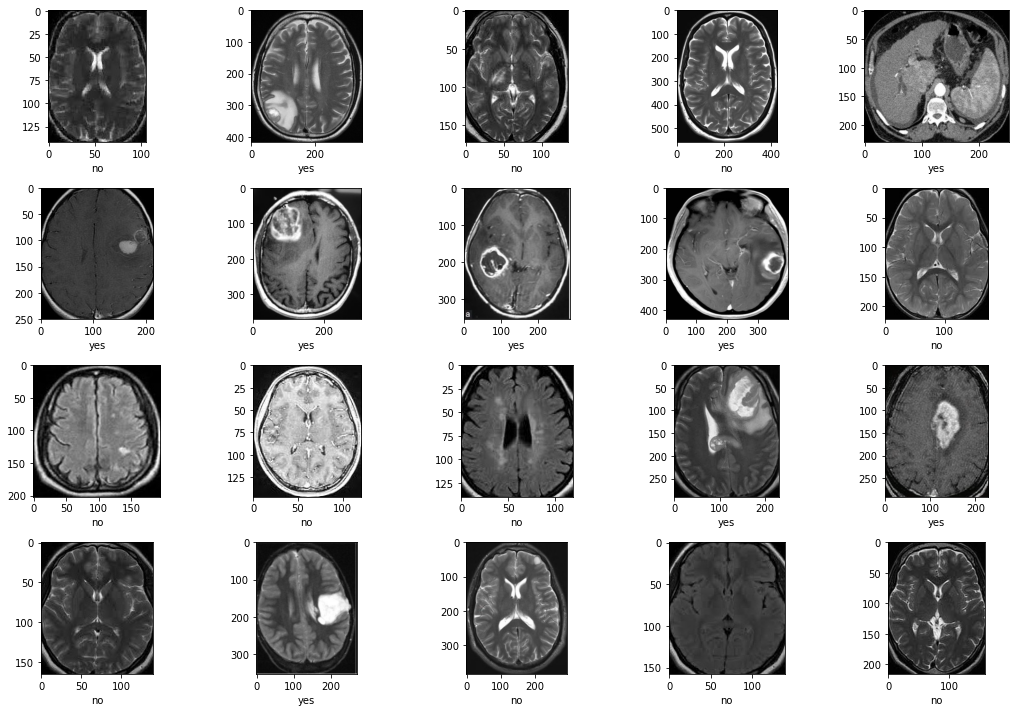

In [3]:
def plot_samples(img_path,n=20):
    files_list = []
    labels_list = []
    for path, subdirs, files in os.walk(img_path):
        for name in files:
            files_list.append(os.path.join(path, name))
            labels_list.append(path.split('/')[1])
    imgs_lbls = list(zip(files_list, labels_list))
    random.shuffle(imgs_lbls)
    files_list, labels_list = zip(*imgs_lbls)
    j = 5
    i = int(n/j)
    plt.figure(figsize=(15,10))
    k = 1
    for file, lbl in zip(files_list[:n], labels_list[:n]):
        img = cv2.imread(file)
        plt.subplot(i,j,k)
        plt.imshow(img)
        plt.xlabel(lbl)
        k += 1
    plt.tight_layout()
    plt.show()
    
plot_samples(IMG_PATH)

## Train-time data augmentation
Generalizability is crucial to a deep learning model and it refers to the performance difference of a model when evaluated on the seen data (training data) versus the unseen data (testing data). Improving the generalizability of these models has always been a difficult challenge. 

<img src="files/img.jpg">


**Data Augmentation** is an effective way of improving the generalizability, because the augmented data will represent a more comprehensive set of possible data samples and minimizing the distance between the training and validation/testing sets.

There are many data augmentation methods you can choose in this projects including rotation, shifting, flipping, etc. Some examples you can apply in this project are given here:

**[rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, brightness_range=[0.5, 1.5], horizontal_flip=True, vertical_flip=True]**

More methods and details can be found at https://keras.io/api/preprocessing/image/.

You are encouraged to try different augmentation method to get the best classification accuracy.

**Question**

Applying data augmentation to medical images may sometimes make the images uninterpretable to human. For instance, a heart may not look like a heart after shearing the image. Would training the model with these uninterpretable images helpful to improving the model performance? Why do you think it is helpful/not helpful?


In [13]:
TRAIN_DIR = 'Train/'
VAL_DIR = 'Val/'
IMG_SIZE = (128,128)
RANDOM_SEED = 100

train_datagen = ImageDataGenerator(
    #add your augmentation methods here
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

## Get the data generator ready

You may change the batch size of your training data here. A large batch size or even a batch size that equals to the entire dataset is more likely to get your model to the convergence to the global optima of the loss function, but this is at the cost of computational efficiency and sometimes large batch size would lead to a bad model generalisation. 

There is always a trade-off between large and small batch size. Choose a reasonable batch size here to get the best model performance.

In [14]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    interpolation='bicubic',
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    interpolation='bicubic',
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 152 images belonging to 2 classes.
Found 37 images belonging to 2 classes.


## Load the backbone model

To extract the features from the dataset, a backbone network is used here. Initially, VGG16 is used here as an example.

To achieve the best classification accuracy, you are encouraged to try different models. A list of models you can try is given at https://keras.io/api/applications/. Remember to update the **Preparing your environment** and **this** part to use a different backbone model, for instance, to use the ResNet50 as the backbone network, change 'from keras.applications.vgg16 import VGG16, preprocess_input' into 'from keras.applications.resnet_v2 import ResNet50, preprocess_input'

These models are pretrained on ImageNet dataset for classification task and you can choose to finetune the pretrained network (transfer learning: https://papers.nips.cc/paper/5347-how-transferable-are-features-in-deep-neural-networks.pdf) or train it from the scratch for the tumour detection task.

VGG16: https://arxiv.org/pdf/1409.1556

ResNet: https://arxiv.org/abs/1512.03385

DenseNet: https://arxiv.org/abs/1608.06993

**Question**

What are the advantages and disadvantages of finetuning a model for tumour detection?

In [15]:
base_model =  ResNet50(
    #uncomment if you want to train your network from scratch.
#     weight = None
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

## Build the model for tumour detection

A classifier is added to the backbone network here. The loss function used to train the model is binary cross entropy (details can be found at https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class and https://machinelearningmastery.com/cross-entropy-for-machine-learning/). 

The optimizer used here is ADAM (https://arxiv.org/abs/1412.6980) and you can leave it unchanged.

In [16]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

# uncomment here if you want to finetune the top layer(classifier) of a pretrained network only. 
# model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 32769     
Total params: 23,620,481
Trainable params: 23,567,361
Non-trainable params: 53,120
_________________________________________________________________


## Train the model
The early stopping would stop the training process when a pre-defined metric stops improving. More details can be found at https://keras.io/api/callbacks/early_stopping/.

In [17]:
num_epochs = 100
# earlystopping = EarlyStopping(
#     monitor='val_acc', 
#     mode='max',
#     patience=40
# )

filepath="weights-improvement-Resnet1280.8-WITHAUG-{epoch:02d}-{val_acc:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,
mode='max')
callbacks_list = [checkpoint]

history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
#     callbacks=[earlystopping]
    callbacks = callbacks_list
)

Epoch 1/100
2/2 [==============================] - 2s 970ms/step - loss: 1.1958 - acc: 0.6757A: 1s - loss: 1.0711 - acc: 0.6

Epoch 00001: val_acc improved from -inf to 0.67568, saving model to weights-improvement-Resnet1280.8-WITHAUG-01-0.68.h5
10/10 [==============================] - 16s 2s/step - loss: 0.9888 - acc: 0.6250 - val_loss: 1.1958 - val_acc: 0.6757
Epoch 2/100
2/2 [==============================] - 0s 86ms/step - loss: 0.4317 - acc: 0.7568

Epoch 00002: val_acc improved from 0.67568 to 0.75676, saving model to weights-improvement-Resnet1280.8-WITHAUG-02-0.76.h5
10/10 [==============================] - 2s 234ms/step - loss: 0.3279 - acc: 0.8289 - val_loss: 0.4317 - val_acc: 0.7568
Epoch 3/100
2/2 [==============================] - 0s 83ms/step - loss: 0.6673 - acc: 0.7838

Epoch 00003: val_acc improved from 0.75676 to 0.78378, saving model to weights-improvement-Resnet1280.8-WITHAUG-03-0.78.h5
10/10 [==============================] - 3s 276ms/step - loss: 0.3003 - acc: 0.8

Epoch 30/100
2/2 [==============================] - 0s 85ms/step - loss: 0.2169 - acc: 0.8378

Epoch 00030: val_acc did not improve from 0.91892
10/10 [==============================] - 2s 189ms/step - loss: 0.0082 - acc: 1.0000 - val_loss: 0.2169 - val_acc: 0.8378
Epoch 31/100
2/2 [==============================] - 0s 86ms/step - loss: 0.2379 - acc: 0.8649

Epoch 00031: val_acc did not improve from 0.91892
10/10 [==============================] - 2s 189ms/step - loss: 0.0318 - acc: 0.9868 - val_loss: 0.2379 - val_acc: 0.8649
Epoch 32/100
2/2 [==============================] - 0s 96ms/step - loss: 0.2201 - acc: 0.8649

Epoch 00032: val_acc did not improve from 0.91892
10/10 [==============================] - 2s 192ms/step - loss: 0.0096 - acc: 1.0000 - val_loss: 0.2201 - val_acc: 0.8649
Epoch 33/100
2/2 [==============================] - 0s 91ms/step - loss: 0.2552 - acc: 0.8919

Epoch 00033: val_acc did not improve from 0.91892
10/10 [==============================] - 2s 192ms/step - 

Epoch 61/100
2/2 [==============================] - 0s 89ms/step - loss: 0.2169 - acc: 0.9189

Epoch 00061: val_acc did not improve from 0.91892
10/10 [==============================] - 2s 188ms/step - loss: 0.0055 - acc: 1.0000 - val_loss: 0.2169 - val_acc: 0.9189
Epoch 62/100
2/2 [==============================] - 0s 88ms/step - loss: 0.3059 - acc: 0.8919

Epoch 00062: val_acc did not improve from 0.91892
10/10 [==============================] - 2s 189ms/step - loss: 0.0123 - acc: 0.9934 - val_loss: 0.3059 - val_acc: 0.8919
Epoch 63/100
2/2 [==============================] - 0s 86ms/step - loss: 0.3083 - acc: 0.8919

Epoch 00063: val_acc did not improve from 0.91892
10/10 [==============================] - 2s 189ms/step - loss: 7.8694e-04 - acc: 1.0000 - val_loss: 0.3083 - val_acc: 0.8919
Epoch 64/100
2/2 [==============================] - 0s 90ms/step - loss: 0.3224 - acc: 0.8919

Epoch 00064: val_acc did not improve from 0.91892
10/10 [==============================] - 2s 187ms/ste

Epoch 92/100
2/2 [==============================] - 0s 89ms/step - loss: 0.2795 - acc: 0.8649

Epoch 00092: val_acc did not improve from 0.94595
10/10 [==============================] - 2s 188ms/step - loss: 0.0226 - acc: 0.9868 - val_loss: 0.2795 - val_acc: 0.8649
Epoch 93/100
2/2 [==============================] - 0s 85ms/step - loss: 0.2484 - acc: 0.8919

Epoch 00093: val_acc did not improve from 0.94595
10/10 [==============================] - 2s 188ms/step - loss: 5.7910e-04 - acc: 1.0000 - val_loss: 0.2484 - val_acc: 0.8919
Epoch 94/100
2/2 [==============================] - 0s 87ms/step - loss: 0.2358 - acc: 0.8649

Epoch 00094: val_acc did not improve from 0.94595
10/10 [==============================] - 2s 189ms/step - loss: 0.0285 - acc: 0.9868 - val_loss: 0.2358 - val_acc: 0.8649
Epoch 95/100
2/2 [==============================] - 0s 87ms/step - loss: 0.2177 - acc: 0.8919

Epoch 00095: val_acc did not improve from 0.94595
10/10 [==============================] - 2s 188ms/ste

## Plot training result##

**Question**

What causes the gap between training accuracy/loss and test accuracy/loss? How do you reduce the gap between training accuracy/loss and test accuracy/loss?

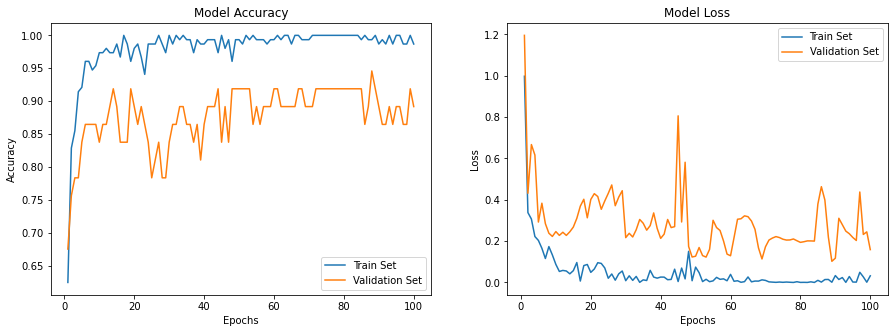

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

## Accuracy on validation set
Getting the accuracy on the validation set.

In [19]:
def load_data(dir_path, img_size=IMG_SIZE):
    X = []
    y = []
    i = 0
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = cv2.resize(img, dsize=img_size, interpolation=cv2.INTER_CUBIC)
                    X.append(preprocess_input(img))
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y

X_val, y_val = load_data(VAL_DIR)
predictions = model.predict(X_val)
print(predictions)
predictions = [1 if x>0.5 else 0 for x in predictions]
accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 29.92it/s]


37 images loaded from Val/ directory.
[[1.1622906e-06]
 [7.0601702e-05]
 [3.9264560e-04]
 [2.1165609e-02]
 [4.1600764e-03]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.5073436e-01]
 [0.0000000e+00]
 [1.6772747e-04]
 [8.6426735e-07]
 [0.0000000e+00]
 [0.0000000e+00]
 [9.2110550e-01]
 [1.0000000e+00]
 [1.0000000e+00]
 [4.4420958e-03]
 [9.9998844e-01]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [9.6710902e-01]
 [8.4912324e-01]
 [6.0416359e-01]
 [1.3226390e-01]
 [1.0000000e+00]
 [5.3670424e-01]
 [1.0000000e+00]
 [1.0000000e+00]
 [9.9999970e-01]
 [9.9999917e-01]
 [1.0000000e+00]
 [9.9999988e-01]
 [1.0000000e+00]
 [1.0000000e+00]
 [9.9906141e-01]]
Val Accuracy = 0.92


## Save your trained model
If you feel your model has been trained to convergence, save it here.

In [11]:
model.save('trained_modelresenet192.h5')

## Test the model (For last project Q&A session)
Test your trained model here.

In [22]:
TEST_DIR = 'Val1/'
IMG_SIZE = (224,224)
#load your model here
model1 = load_model('weights-improvement-10-1.00.h5')
model2 = load_model('weights-improvement-Resnet1920.8-WITHAUG-50-0.95.h5')
model3 = load_model('weights-improvement-Resnet1280.8-WITHAUG-88-0.95.h5')
def load_data(dir_path, img_size=IMG_SIZE):
    X = []
    y = []
    i = 0
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = cv2.resize(img, dsize=img_size, interpolation=cv2.INTER_CUBIC)
                    X.append(preprocess_input(img))
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y


X_test1, y_test = load_data(TEST_DIR)

X_test2,y_test = load_data(TEST_DIR,(192,192))

X_test3, y_test = load_data(TEST_DIR,(128,128))


predictions1 = model1.predict(X_test1)

predictions2 = model2.predict(X_test2)

predictions3 = model3.predict(X_test3)

predictions = (predictions1 + predictions2 + predictions3) / 3

print(predictions)
predictions = [1 if x>0.5 else 0 for x in predictions]
accuracy = accuracy_score(y_test, predictions)
print('Val Accuracy = %.2f' % accuracy)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

75 images loaded from Val1/ directory.


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

75 images loaded from Val1/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.64it/s]


75 images loaded from Val1/ directory.
[[2.83659506e-03]
 [4.23948979e-03]
 [3.85443382e-05]
 [1.11103058e-04]
 [6.71495975e-04]
 [1.50501728e-03]
 [1.47720175e-05]
 [1.61727276e-05]
 [2.18033791e-04]
 [4.47034836e-07]
 [1.37090683e-06]
 [3.32792592e-06]
 [8.90394076e-05]
 [1.96297970e-05]
 [5.66244125e-07]
 [4.47034836e-07]
 [1.88748038e-06]
 [6.99897588e-04]
 [1.54212117e-03]
 [1.98373199e-03]
 [8.01136077e-04]
 [9.10957624e-06]
 [2.10482883e-03]
 [2.32974932e-01]
 [7.76847173e-06]
 [1.00324549e-04]
 [1.68879822e-07]
 [3.85443382e-05]
 [1.00000000e+00]
 [9.99999940e-01]
 [9.99999583e-01]
 [9.30643082e-01]
 [1.00000000e+00]
 [9.99617636e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [9.99987781e-01]
 [9.99999821e-01]
 [1.00000000e+00]
 [9.99999762e-01]
 [9.99993563e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [9.99634027e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [9.99999046e-01]
 [9.99998569e-01]
 [9.98123944e-01]
 [1.00000000e+00]
 [9.69954312e-01]
 [1.000

## Covid19
You can also try to classify lung CT images with or without infection. 

In [ ]:
!rm -rf Train_covid Val_covid
!mkdir Train_covid Val_covid Train_covid/yes Train_covid/no Val_covid/yes Val_covid/no

IMG_PATH = 'covid19/'
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        files = os.listdir(IMG_PATH + CLASS)
        random.shuffle(files)
        IMG_NUM = len(files)
        for (n, FILE_NAME) in enumerate(files):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            # 80% of images will be used for training, change the number here 
            # to use different number of images for training your model.
            if n < 0.8*IMG_NUM:
                shutil.copy(img, 'Train_covid/'+ CLASS + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'Val_covid/'+ CLASS + '/' + FILE_NAME)


def plot_samples(img_path,n=20):
    files_list = []
    labels_list = []
    for path, subdirs, files in os.walk(img_path):
        for name in files:
            files_list.append(os.path.join(path, name))
            labels_list.append(path.split('/')[1])
    imgs_lbls = list(zip(files_list, labels_list))
    random.shuffle(imgs_lbls)
    files_list, labels_list = zip(*imgs_lbls)
    j = 5
    i = int(n/j)
    plt.figure(figsize=(15,10))
    k = 1
    for file, lbl in zip(files_list[:n], labels_list[:n]):
        img = cv2.imread(file)
        plt.subplot(i,j,k)
        plt.imshow(img)
        plt.xlabel(lbl)
        k += 1
    plt.tight_layout()
    plt.show()
    
plot_samples(IMG_PATH)

TRAIN_DIR = 'Train_covid/'
VAL_DIR = 'Val_covid/'
IMG_SIZE = (224,224)
RANDOM_SEED = 100

train_datagen = ImageDataGenerator(
    #add your augmentation methods here
    #rotation_range=15,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    interpolation='bicubic',
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    interpolation='bicubic',
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


base_model = VGG16(
    #uncomment if you want to train your network from scratch.
    #weight = None
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

# uncomment here if you want to finetune the top layer(classifier) of a pretrained network only. 
# model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

num_epochs = 200
earlystopping = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=20
)

history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=[earlystopping]
)

## Validation

In [ ]:
def load_data(dir_path, img_size=IMG_SIZE):
    X = []
    y = []
    i = 0
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = cv2.resize(img, dsize=img_size, interpolation=cv2.INTER_CUBIC)
                    X.append(preprocess_input(img))
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y

X_val, y_val = load_data(VAL_DIR)
predictions = model.predict(X_val)
print(predictions)
predictions = [1 if x>0.5 else 0 for x in predictions]
accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)